In [2]:
import os
import re
import sys
import math 
import fiona
import random
import logging
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import skimage
import skimage.draw
import pyproj
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Grid by myself

In [45]:
def get_grid_idx(cell_size=64, height=2357, width=1892):
    num_h = math.ceil(height / cell_size)
    num_w = math.ceil(width / cell_size)
    num_range = np.arange(num_h * num_w).reshape(num_h, num_w)
    print(f'There are {num_h * num_w} grid groups in total.')
    grid_idx = num_range.repeat(cell_size, axis=0).repeat(cell_size, axis=1)
    print(f'before: {grid_idx.shape}')
    grid_idx = grid_idx[:height, :width]
    print(f'after: {grid_idx.shape}')
    return grid_idx

In [46]:
grid_idx = get_grid_idx()

There are 1110 grid groups in total.
before: (2368, 1920)
after: (2357, 1892)


In [47]:
1110*0.2

222.0

In [51]:
grid_idx_test = random.sample(list(np.arange(1110)), math.ceil(1110*0.2))
grid_idx_train_val = list(set(np.arange(1110)) - set(grid_idx_test))

In [296]:
pred_path = '../preds/1008-183014_rfc.tif'
band_pred, meta_pred = load_geotiff(pred_path)

In [162]:
def visualize_train_test_grid_split(meta_src, grid_idx_test, grid_idx_train_val, spatial_dict, save_path):
    # get the grid idx
    cell_size, height, width = spatial_dict['cell_size'], spatial_dict['height'], spatial_dict['width']
    grid_idx = get_grid_idx(cell_size, height, width).reshape(-1)
    # build 
    output = np.zeros_like(grid_idx)
    test_mask = [True if idx in grid_idx_test else False for idx in grid_idx]
    train_val_mask = [True if idx in grid_idx_train_val else False for idx in grid_idx]
    output[test_mask] = 1
    output[train_val_mask] = 2
    
    with rasterio.Env():
        # Write an array as a raster band to a new 8-bit file. We start with the profile of the source
        out_meta = meta_src.copy()
        out_meta.update(
            dtype=rasterio.uint8,
            count=1,
            compress='lzw')
        with rasterio.open(save_path, 'w', **out_meta) as dst:
            # reshape into (band, height, width)
            dst.write(output.reshape(1, out_meta['height'], out_meta['width']).astype(rasterio.uint8))
            dst.write_colormap(
            1, {
                0: (0, 0, 0), 
                1: (240, 72, 72),
                2: (71, 208, 240)})
            
def load_geotiff(path, window=None):
    """ Load the geotiff as a list of numpy array.
        INPUT : path (str) -> the path to the geotiff
                window (rasterio.windows.Window) -> the window to use when loading the image
        OUTPUT : band (list of numpy array) -> the different bands as float scaled to 0:1
                 meta (dictionary) -> the metadata associated with the geotiff
    """
    with rasterio.open(path) as f:
        band = [skimage.img_as_float(f.read(i+1, window=window)) for i in range(f.count)]
        meta = f.meta
        if window is not None:
            meta['height'] = window.height
            meta['width'] = window.width
            meta['transform'] = f.window_transform(window)
    return band, meta

In [67]:
spatial_dict = {'cell_size': 64, 'height': meta_pred['height'], 'width': meta_pred['width']}
visualize_train_test_grid_split(meta_pred, grid_idx_test, grid_idx_train_val, spatial_dict, './train_test_split.tiff')

There are 1110 grid groups in total.
before: (2368, 1920)
after: (2357, 1892)


In [1]:
1

1

In [2]:
class Model(object):
    def __init__(self, logger, log_time, model_name):
        self._logger = logger
        self._log_time = log_time
        self.model_name = model_name

    def _check_model_name(self, model_list):
        if self.model_name not in model_list:
            raise ValueError(f'No such model {self.model_name}. Please choose from {model_list}.')
    
    def fit_best(self):
        raise NotImplementedError

In [3]:
class ModelCropland(Model):
    def __init__(self, logger, log_time, model_name):
        super().__init__(logger, log_time, model_name)
        self._check_model_name(model_list=['svc', 'rfc', 'mlp', 'gru'])
        self.best_params = None
        self.model = None
    
    def fit_best(self, arg):
        print(f'Fit best in ModelCropSpecific with arg {arg}')

In [14]:
class ModelCropSpecific(Model):
    def __init__(self, logger, log_time, model_name, pretrained_name=None):
        super().__init__(logger, log_time, model_name)
        self._check_model_name(model_list=['ocsvm', 'pul', 'pul-w'])
        if pretrained_name is None:
            self.base_model = None
            print('Train from scratch.')
        else:
            self.base_model = pretrained_name
            print(f'Loaded pretrained model {pretrained_name}.')
        
        self.best_params = None
        self.model = None
        
    def fit_best(self, arg):
        print(f'Fit best in ModelCropSpecific with arg {arg}')
        
    def evaluate(self):
        print('Add evaluation method')

In [5]:
model_c = ModelCropland('logger', 'log_time', 'model')

ValueError: No such model model. Please choose from ['svc', 'rfc', 'mlp', 'gru'].

In [7]:
model_c = ModelCropland('logger', 'log_time', 'svc')
model_c.fit_best('xx')

Fit best in ModelCropSpecific with arg xx


In [8]:
model_cs = ModelCropland('logger', 'log_time', 'model')

ValueError: No such model model. Please choose from ['svc', 'rfc', 'mlp', 'gru'].

In [12]:
model_cs = ModelCropSpecific('logger', 'log_time', 'ocsvm')
model_cs.fit_best('yy')

Train from scratch.
Fit best in ModelCropSpecific with arg yy


In [15]:
model_cs = ModelCropSpecific('logger', 'log_time', 'ocsvm', 'pretrained_model')
model_cs.fit_best('yy')
model_cs.evaluate()

Loaded pretrained model pretrained_model.
Fit best in ModelCropSpecific with arg yy
Add evaluation method


In [16]:
import numpy as np

In [20]:
a = np.zeros((5,2))
a

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [21]:
np.concatenate([a,a], axis=0)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [22]:
import pandas as pd

In [25]:
x = pd.DataFrame([[1,2],[2,3]], columns=list('ab'))

In [26]:
x

,a,b
0,1,2
1,2,3


In [29]:
x.a.values.shape

(2,)

In [31]:
from src.util import load_target_shp, compute_mask

ModuleNotFoundError: No module named 'src'

In [32]:
from .src.util import load_target_shp, compute_mask

ImportError: attempted relative import with no known parent package

In [33]:
from ..src.util import load_target_shp, compute_mask

ImportError: attempted relative import with no known parent package

In [23]:
import os
import re
import sys
import math
import fiona
import logging
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import skimage
import skimage.draw
import pyproj
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

def load_geotiff(path, window=None):
    """ Load the geotiff as a list of numpy array.
        INPUT : path (str) -> the path to the geotiff
                window (rasterio.windows.Window) -> the window to use when loading the image
        OUTPUT : band (list of numpy array) -> the different bands as float scaled to 0:1
                 meta (dictionary) -> the metadata associated with the geotiff
    """
    with rasterio.open(path) as f:
        band = [skimage.img_as_float(f.read(i + 1, window=window)) for i in range(f.count)]
        meta = f.meta
        if window is not None:
            meta['height'] = window.height
            meta['width'] = window.width
            meta['transform'] = f.window_transform(window)
    return band, meta

def load_target_shp(path, transform=None, proj_out=None):
    """ Load the shapefile as a list of numpy array of coordinates
        INPUT : path (str) -> the path to the shapefile
                transform (rasterio.Affine) -> the affine transformation to get the polygon in row;col format from UTM.
        OUTPUT : poly (list of np.array) -> list of polygons (as numpy.array of coordinates)
                 poly_rc (list of np.array) -> list of polygon in row-col format if a transform is given
    """
    print("Loading target shapefile...")
    with fiona.open(path) as shapefile:
        proj_in = pyproj.Proj(shapefile.crs)
        class_type = [feature['properties']['id'] for feature in shapefile]
        features = [feature["geometry"] for feature in shapefile]
    # re-project polygons if necessary
    if proj_out is None or proj_in == proj_out:
        poly = [np.array([(coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i in
                range(len(features))]
        print('No re-projection!')
    else:
        poly = [np.array(
            [pyproj.transform(proj_in, proj_out, coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i
            in range(len(features))]
        print(f'Re-project from {proj_in} to {proj_out}')

    poly_rc = None
    # transform in row-col if a transform is given
    if transform is not None:
        poly_rc = [np.array([rasterio.transform.rowcol(transform, coord[0], coord[1])[::-1] for coord in p]) for p in
                   poly]
    print('Loaded target shape files.')

    return features, poly, poly_rc, class_type


def compute_mask(polygon_list, meta, val_list):
    """ Get mask of class of a polygon list
        INPUT : polygon_list (list od polygon in coordinates (x, y)) -> the polygons in row;col format
                meta -> the image width and height
                val_list(list of int) -> the class associated with each polygon
        OUTPUT : img (np.array 2D) -> the mask in which the pixel value reflect it's class (zero being the absence of class)
    """
    img = np.zeros((meta['height'], meta['width']), dtype=np.uint8)  # skimage : row,col --> h,w
    i = 0
    for polygon, val in zip(polygon_list, val_list):
        rr, cc = skimage.draw.polygon(polygon[:, 1], polygon[:, 0], img.shape)
        img[rr, cc] = val
        i += 1
    print("Added targets' mask.")
    return img

In [20]:
img_dir = 'N:/dataorg-datasets/MLsatellite/sentinel2_images/images_danya/geotiff/'
eg = img_dir + 'L2A_T43SFR_A026271_20200703T053446.tiff'
band, meta = load_geotiff(eg)

In [41]:
def count_classes(logger, y):
    tot_num = len(y)
    for i in np.unique(y):
        y_i = y[y == i]
        msg = f'  label = {i}, pixel number = {y_i.shape[0]}, percentage = {round(len(y_i) / tot_num * 100, 2)}%'
        if logger is None:
            print(msg)
        else:
            logger.info(msg)

In [24]:
test_features, test_polygons, test_rc_polygons, test_class_list = \
    load_target_shp('../data/test_polygons/test_polygons.shp',
                    transform=meta['transform'],
                    proj_out=pyproj.Proj(meta['crs']))
test_mask = compute_mask(test_rc_polygons, meta, test_class_list)

Loading target shapefile...


C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\lida\AppData\Local\Temp/ipykernel_104/1212342569.py:53: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  [pyproj.transform(proj_in, proj_out, coord[0], coord[1]) for coord in features[i]['coordinates'][0]]) for i


Re-project from proj=longlat datum=WGS84 no_defs ellps=WGS84 towgs84=0,0,0 to proj=utm zone=43 datum=WGS84 units=m no_defs ellps=WGS84 towgs84=0,0,0
Loaded target shape files.
Added targets' mask.


In [25]:
test_features

[{'type': 'Polygon',
  'coordinates': [[(77.11556966552818, 31.932980415461877),
    (77.11634053329385, 31.933312941652222),
    (77.11672809664566, 31.932814151915665),
    (77.11695382035603, 31.93200451643682),
    (77.11591463950066, 31.931802106453013),
    (77.11556966552818, 31.932980415461877)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.11564632641094, 31.951965011532938),
    (77.11564632641094, 31.952962380430723),
    (77.11683882903188, 31.952962380430723),
    (77.11683882903188, 31.951965011532938),
    (77.11564632641094, 31.951965011532938)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.11832093943218, 31.951957784182568),
    (77.11832093943218, 31.95286842585163),
    (77.11929197728065, 31.95286842585163),
    (77.11929197728065, 31.951957784182568),
    (77.11832093943218, 31.951957784182568)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.12413013077123, 31.953047300833003),
    (77.12413013077123, 31.954073566721306),
    (77.12535670489562, 31.9540735667213

In [58]:
test_labeled = train_mask.reshape(-1)
test_labeled = test_labeled[test_labeled!=0]

In [59]:
count_classes(None, test_labeled)

  label = 2, pixel number = 7318, percentage = 47.78%
  label = 3, pixel number = 7999, percentage = 52.22%


## Spacv

In [1]:
import spacv
import geopandas as gpd
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Program Files\GDAL\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.



In [300]:
df = gpd.read_file('../data_cv/baltim.geojson')

XYs = df['geometry']
X = df[['NROOM', 'BMENT', 'NBATH', 'PRICE', 'LOTSZ', 'SQFT']]
y = df['PATIO']

XYs.shape, X.shape, y.shape

((211,), (211, 6), (211,))

In [306]:
df.type

0      Point
1      Point
2      Point
3      Point
4      Point
       ...  
206    Point
207    Point
208    Point
209    Point
210    Point
Length: 211, dtype: object

In [303]:
XYs.dtype

In [302]:
df.head()

,STATION,PRICE,NROOM,DWELL,NBATH,PATIO,FIREPL,AC,BMENT,NSTOR,GAR,AGE,CITCOU,LOTSZ,SQFT,X,Y,geometry
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,POINT (920.000 581.000)
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,POINT (923.000 578.000)
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,POINT (918.000 574.000)


In [388]:
XYs.dtype

In [392]:
XYs

0      POINT (907.000 534.000)
1      POINT (922.000 574.000)
2      POINT (920.000 581.000)
3      POINT (923.000 578.000)
4      POINT (918.000 574.000)
                ...           
206    POINT (940.000 538.500)
207    POINT (945.500 553.000)
208    POINT (914.000 553.000)
209    POINT (919.000 554.000)
210    POINT (914.000 558.000)
Name: geometry, Length: 211, dtype: geometry

In [24]:
# Build fold indices as a generator
skcv = spacv.SKCV(n_splits=4, buffer_radius=10)gpd.points_from_xy(XYs)

In [25]:
trains, tests = [], []
len_tr, len_te = 0, 0
for tr, te in skcv.split(XYs):
    len_tr += tr.shape[0]
    len_te += te.shape[0]
    trains.append(tr)
    tests.append(te)
print(f'len_tr: {len_tr}, len_te: {len_te}')

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\sklearn\cluster\_kmeans.py:1045: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


len_tr: 534, len_te: 211


C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\base_classes.py:69: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  deadzone_points = gpd.sjoin(candidate_deadzone, geometry_buffer)
C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\base_classes.py:69: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  deadzone_points = gpd.sjoin(candidate_deadzone, geometry_buffer)
C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\base_classes.py:69: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:432

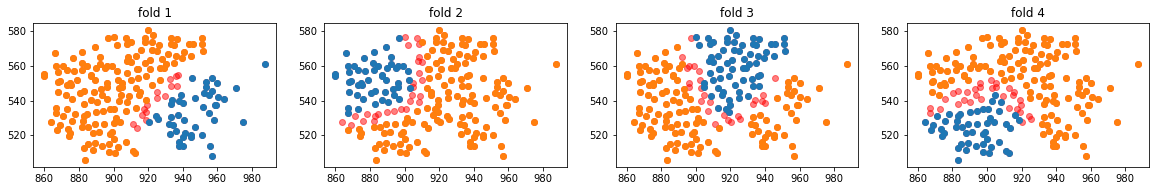

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, (train_id, test_id) in enumerate(zip(trains, tests)):
    XYs.plot(aspect=1, ax=axs[i], color='r', alpha=0.5)
    XYs[test_id].plot(aspect=1, ax=axs[i])
    XYs[train_id].plot(aspect=1, ax=axs[i])
    axs[i].set_title(f'fold {i+1}')

In [20]:
trains

[array([  1,   2,   3,   4,   6,   8,  10,  12,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  24,  71,  72,  73,  74,  75,  93,  94,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
        122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
        135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 166, 167, 170, 171, 172, 173, 174, 175, 176, 177, 178,
        179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
        205, 206, 207, 209], dtype=int64),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        

In [21]:
tests

[array([ 5,  9, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41,
        42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 60, 61, 62, 63, 69, 76, 77, 78, 79, 80, 81, 82, 85, 86],
       dtype=int64),
 array([ 16,  17,  18,  20,  21,  22,  71,  72,  73,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 133, 134, 135, 136, 137, 138, 178, 202, 203,
        204, 205, 206, 207], dtype=int64),
 array([  0,  15,  30,  40,  83,  84,  87,  88,  89,  90,  92,  95, 130,
        131, 132, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
        150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
        176, 177], dtype=int64),
 array([  1,   2,   3,   4,   6,   7,   8,  10,  11,  12,  13,  14,  19,
         23,  24,  64,  6

In [12]:
from spacv.grid_builder import construct_blocks, assign_pt_to_grid, construct_grid

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [15]:
grid = construct_grid(XYs, tiles_x=5, tiles_y=3, shape='square')

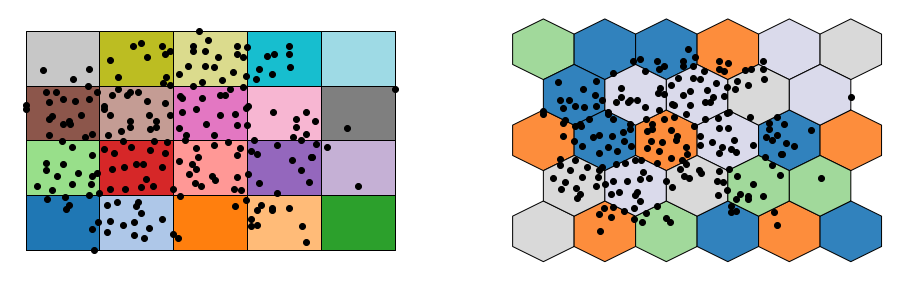

In [66]:
f, ax = plt.subplots(1,2, figsize=(16,16))

grid_blocks = construct_blocks(XYs, tiles_x=5, tiles_y=4, method='unique')
grid_blocks.plot(column='grid_id', edgecolor='black', cmap='tab20',ax=ax[0])

hex_blocks = construct_blocks(XYs, tiles_x=5, tiles_y=2, 
                 method='random', n_sims=10, data=X,
                 n_groups=5, shape='hex')
hex_blocks.plot(column='grid_id', cmap='tab20c',ax=ax[1], edgecolor='black')

XYs.plot(ax=ax[0], color='black', aspect=1)
XYs.plot(ax=ax[1], color='black', aspect=1)
ax[0].axis('off'), ax[1].axis('off')
plt.show()

In [67]:
grid_blocks

,geometry,grid_id
0,"POLYGON ((860.000 505.500, 885.500 505.500, 88...",0
1,"POLYGON ((885.500 505.500, 911.000 505.500, 91...",1
2,"POLYGON ((911.000 505.500, 936.500 505.500, 93...",2
3,"POLYGON ((936.500 505.500, 962.000 505.500, 96...",3
4,"POLYGON ((962.000 505.500, 987.500 505.500, 98...",4
5,"POLYGON ((860.000 524.375, 885.500 524.375, 88...",5
6,"POLYGON ((885.500 524.375, 911.000 524.375, 91...",6
7,"POLYGON ((911.000 524.375, 936.500 524.375, 93...",7
8,"POLYGON ((936.500 524.375, 962.000 524.375, 96...",8
9,"POLYGON ((962.000 524.375, 987.500 524.375, 98...",9


In [54]:
XYs

0      POINT (907.000 534.000)
1      POINT (922.000 574.000)
2      POINT (920.000 581.000)
3      POINT (923.000 578.000)
4      POINT (918.000 574.000)
                ...           
206    POINT (940.000 538.500)
207    POINT (945.500 553.000)
208    POINT (914.000 553.000)
209    POINT (919.000 554.000)
210    POINT (914.000 558.000)
Name: geometry, Length: 211, dtype: geometry

In [19]:
from spacv.utils import convert_geodataframe

In [55]:
XYs_df = convert_geodataframe(XYs)  

In [56]:
XYs_df

,geometry
0,POINT (907.000 534.000)
1,POINT (922.000 574.000)
2,POINT (920.000 581.000)
3,POINT (923.000 578.000)
4,POINT (918.000 574.000)
...,...
206,POINT (940.000 538.500)
207,POINT (945.500 553.000)
208,POINT (914.000 553.000)
209,POINT (919.000 554.000)


In [70]:
XYs_assigned = assign_pt_to_grid(XYs, grid_blocks)

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\grid_builder.py:267: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid = grid.geometry.centroid


In [71]:
XYs_assigned

,geometry,grid_id
0,POINT (907.000 534.000),6.0
1,POINT (922.000 574.000),17.0
2,POINT (920.000 581.000),17.0
3,POINT (923.000 578.000),17.0
4,POINT (918.000 574.000),17.0
...,...,...
206,POINT (940.000 538.500),8.0
207,POINT (945.500 553.000),13.0
208,POINT (914.000 553.000),12.0
209,POINT (919.000 554.000),12.0


In [72]:
grid_ids = np.unique(grid_blocks.grid_id)

In [73]:
grid_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=int64)

In [46]:
import numpy as np

In [75]:
XYs_assigned.grid_id.unique()

array([ 6., 17., 16., 12.,  7., 10.,  5., 11., 15.,  3., 13., 14.,  8.,
        9.,  2.,  1.,  0., 18.])

In [76]:
grid_blocks

,geometry,grid_id
0,"POLYGON ((860.000 505.500, 885.500 505.500, 88...",0
1,"POLYGON ((885.500 505.500, 911.000 505.500, 91...",1
2,"POLYGON ((911.000 505.500, 936.500 505.500, 93...",2
3,"POLYGON ((936.500 505.500, 962.000 505.500, 96...",3
4,"POLYGON ((962.000 505.500, 987.500 505.500, 98...",4
5,"POLYGON ((860.000 524.375, 885.500 524.375, 88...",5
6,"POLYGON ((885.500 524.375, 911.000 524.375, 91...",6
7,"POLYGON ((911.000 524.375, 936.500 524.375, 93...",7
8,"POLYGON ((936.500 524.375, 962.000 524.375, 96...",8
9,"POLYGON ((962.000 524.375, 987.500 524.375, 98...",9


In [109]:
sorted(XYs_assigned.grid_id.unique().astype(int))

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [110]:
valid_grid_blocks = grid_blocks.loc[sorted(XYs_assigned.grid_id.unique().astype(int)), :]

In [111]:
valid_grid_blocks = valid_grid_blocks.rename(columns={'grid_id': 'grid_id_valid'})

In [112]:
valid_grid_blocks

,geometry,grid_id_valid
0,"POLYGON ((860.000 505.500, 885.500 505.500, 88...",0
1,"POLYGON ((885.500 505.500, 911.000 505.500, 91...",1
2,"POLYGON ((911.000 505.500, 936.500 505.500, 93...",2
3,"POLYGON ((936.500 505.500, 962.000 505.500, 96...",3
5,"POLYGON ((860.000 524.375, 885.500 524.375, 88...",5
6,"POLYGON ((885.500 524.375, 911.000 524.375, 91...",6
7,"POLYGON ((911.000 524.375, 936.500 524.375, 93...",7
8,"POLYGON ((936.500 524.375, 962.000 524.375, 96...",8
9,"POLYGON ((962.000 524.375, 987.500 524.375, 98...",9
10,"POLYGON ((860.000 543.250, 885.500 543.250, 88...",10


In [93]:
from spacv.grid_builder import assign_pt_to_grid, construct_grid, assign_randomized, assign_systematic, assign_optimized_random

In [123]:
def assign_grid_to_fold(XYs, grid, tiles_x, tiles_y, method='unique', shape='square', 
                     direction='diagonal', data=None, n_groups=5, n_sims=10, 
                     distance_metric='euclidean', random_state=None):
    # Set grid assignment method
    if method == 'unique':
        grid['grid_id'] = grid.index
    elif method == 'systematic':
        if shape != 'square':
            raise Exception("systematic grid assignment method does not work for irregular grids.")
        grid['grid_id'] = assign_systematic(grid, tiles_x, tiles_y, direction)
    elif method == 'random':
        grid['grid_id'] = assign_randomized(grid, n_groups, random_state)
    elif method == 'optimized_random':
        grid['grid_id'] = assign_optimized_random(grid, XYs, data, 
                                                             n_groups,
                                                             n_sims, 
                                                             distance_metric)
    else:
        raise ValueError("Method not recognised. Choose between: unique, systematic, random or optimized_random.")
    return grid

In [119]:
new_grid = assign_grid_fold(XYs, valid_grid_blocks, 5, 4, method='random')

In [120]:
new_grid

,geometry,grid_id_valid,grid_id
0,"POLYGON ((860.000 505.500, 885.500 505.500, 88...",0,0
1,"POLYGON ((885.500 505.500, 911.000 505.500, 91...",1,1
2,"POLYGON ((911.000 505.500, 936.500 505.500, 93...",2,2
3,"POLYGON ((936.500 505.500, 962.000 505.500, 96...",3,0
5,"POLYGON ((860.000 524.375, 885.500 524.375, 88...",5,2
6,"POLYGON ((885.500 524.375, 911.000 524.375, 91...",6,3
7,"POLYGON ((911.000 524.375, 936.500 524.375, 93...",7,2
8,"POLYGON ((936.500 524.375, 962.000 524.375, 96...",8,2
9,"POLYGON ((962.000 524.375, 987.500 524.375, 98...",9,2
10,"POLYGON ((860.000 543.250, 885.500 543.250, 88...",10,1


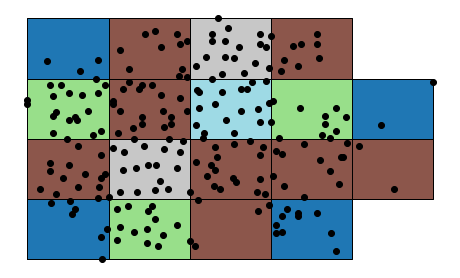

In [121]:
f, ax = plt.subplots(1,1, figsize=(8,8))

new_grid.plot(column='grid_id', edgecolor='black', cmap='tab20',ax=ax, aspect=1)

XYs.plot(ax=ax, color='black', aspect=1)
ax.axis('off')
plt.show()

In [125]:
from spacv.base_classes import BaseSpatialCV 

In [145]:
from spacv.utils import convert_geoseries

In [157]:
class BlockRandomCV(BaseSpatialCV):
    def __init__(
            self,
            tiles_x=5,
            tiles_y=5,
            shape='square',
            method='unique',
            buffer_radius=0,
            direction='diagonal',
            n_groups=5,
            data=None,
            n_sims=10,
            distance_metric='euclidean',
            random_state=None
    ):
        self.tiles_x = tiles_x
        self.tiles_y = tiles_y
        self.shape = shape
        self.method = method
        self.buffer_radius = buffer_radius
        self.direction = direction
        self.n_groups = n_groups
        self.data = data
        self.n_sims = n_sims
        self.distance_metric = distance_metric
        self.n_splits = tiles_x * tiles_y
        self.random_state = random_state

    def _iter_test_indices(self, XYs):
        """
        Generates integer indices corresponding to test sets and
        training indices to be excluded from model training.

        Parameters
        ----------
        XYs : GeoSeries
            GeoSeries containing shapely Points that identify Easting
            and Northing coordinates of data points.

        Yields
        ------
        test_indices : array
            The testing set indices for that fold.
        train_exclude : array
            The training set indices to exclude for that fold.
        """
        # Define grid type used in CV procedure but with only valid blocks
        grid_all = construct_grid(XYs, tiles_x=self.tiles_x, tiles_y=self.tiles_y, shape=self.shape)
        grid_all['grid_id'] = grid_all.index

        # Convert to GDF to use Geopandas functions
        XYs = gpd.GeoDataFrame(({'geometry': XYs}))

        # Assign pts to grids
        XYs = assign_pt_to_grid(XYs, grid_all, self.distance_metric)

        # Find the valid grid with points falling in
        grid_valid = grid_all.loc[sorted(XYs.grid_id.unique().astype(int)), :]
        grid_valid = grid_valid.rename(columns={'grid_id': 'grid_id_valid'})
        grid = assign_grid_to_fold(XYs, grid_valid, self.tiles_x, self.tiles_y, method=self.method, shape=self.shape,
                                   direction=self.direction, data=self.data, n_groups=self.n_groups, n_sims=self.n_sims,
                                   distance_metric=self.distance_metric, random_state=self.random_state)

        # Get the grid ids
        grid_ids = np.unique(grid.grid_id)

        # Yield test indices and optionally training indices within buffer
        for grid_id in grid_ids:
            test_indices = XYs.loc[XYs['grid_id'] == grid_id].index.values
            # Remove empty grids
            if len(test_indices) < 1:
                continue
            
            grid_poly_buffer = grid.loc[[grid_id]].buffer(self.buffer_radius)
            test_indices, train_exclude = \
                super()._remove_buffered_indices(XYs, test_indices,
                                                 self.buffer_radius, grid_poly_buffer)
            yield test_indices, train_exclude
    
    def split(self, XYs):
        """
                Generate indices to split data into training and test set.

                Parameters
                ----------
                XYs : GeoSeries
                    GeoSeries containing shapely Points that identify Easting
                    and Northing coordinates of data points.

                Yields
                ------
                train : ndarray
                    Training set indices for iteration.
                test : ndarray
                    Testing set indices for iteration.
                """
        XYs = convert_geoseries(XYs).reset_index(drop=True)
        minx, miny, maxx, maxy = XYs.total_bounds

        buffer_radius = self.buffer_radius
        if buffer_radius > maxx - minx or buffer_radius > maxy - miny:
            raise ValueError(
                "buffer_radius too large and excludes all points. Given {}.".format(
                    self.buffer_radius
                )
            )
        num_samples = XYs.shape[0]
        indices = XYs.index.values

        for test_indices, train_excluded in self._iter_test_indices(XYs):
            # Exclude the training indices within buffer
            if train_excluded.shape:
                train_excluded = np.concatenate([test_indices, train_excluded])
            else:
                train_excluded = test_indices
            train_index = np.setdiff1d(
                np.union1d(
                    indices,
                    train_excluded
                ), np.intersect1d(indices, train_excluded)
            )
            if len(train_index) < 1:
                raise ValueError(
                    "Training set is empty. Try lowering buffer_radius to include more training instances."
                )
            test_index = indices[test_indices]
            yield train_index, test_index

In [158]:
brcv = BlockRandomCV(5,4,shape='square',method='random')

In [159]:
for tr, va in brcv.split(XYs):
    print(tr, va)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 145 146
 147 148 149 150 151 152 153 154 156 157 158 160 162 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210] [142 143 144 155 159 161 163]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\grid_builder.py:267: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid = grid.geometry.centroid


In [154]:
a = np.empty([], dtype=np.int)

C:\Users\lida\AppData\Local\Temp/ipykernel_2004/2518740872.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = np.empty([], dtype=np.int)


In [155]:
a == np.empty([], dtype=np.int)

C:\Users\lida\AppData\Local\Temp/ipykernel_2004/3885269492.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a == np.empty([], dtype=np.int)


True

In [139]:
from spacv import HBLOCK

In [140]:
hbcv = HBLOCK(5,4,shape='square',method='random')

In [142]:
for tr, va in hbcv.split(XYs):
    print(tr, va)

C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\spacv\grid_builder.py:267: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid = grid.geometry.centroid


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [156]:
a.shape

()

In [197]:
XYs

0      POINT (907.000 534.000)
1      POINT (922.000 574.000)
2      POINT (920.000 581.000)
3      POINT (923.000 578.000)
4      POINT (918.000 574.000)
                ...           
206    POINT (940.000 538.500)
207    POINT (945.500 553.000)
208    POINT (914.000 553.000)
209    POINT (919.000 554.000)
210    POINT (914.000 558.000)
Name: geometry, Length: 211, dtype: geometry

In [198]:
grid

,geometry
0,"POLYGON ((860.000 505.500, 885.500 505.500, 88..."
1,"POLYGON ((885.500 505.500, 911.000 505.500, 91..."
2,"POLYGON ((911.000 505.500, 936.500 505.500, 93..."
3,"POLYGON ((936.500 505.500, 962.000 505.500, 96..."
4,"POLYGON ((962.000 505.500, 987.500 505.500, 98..."
5,"POLYGON ((860.000 530.667, 885.500 530.667, 88..."
6,"POLYGON ((885.500 530.667, 911.000 530.667, 91..."
7,"POLYGON ((911.000 530.667, 936.500 530.667, 93..."
8,"POLYGON ((936.500 530.667, 962.000 530.667, 96..."
9,"POLYGON ((962.000 530.667, 987.500 530.667, 98..."


### get coordinates

In [190]:
transformer = rasterio.transform.AffineTransformer(transform)

AttributeError: module 'rasterio.transform' has no attribute 'AffineTransformer'

In [168]:
transform.xy(0,0)

AttributeError: 'Affine' object has no attribute 'xy'

In [189]:
rasterio.transform.xy(transform, 0, 0)

(77.03216149572383, 32.254462575668086)

In [196]:
rasterio.transform.xy(transform, 0, 1)

(77.03225960464032, 32.254462575668086)

In [174]:
polygons, rc_polygons, class_list = \
    load_target_shp('../data/train_labels/train_labels.shp',
                    transform=meta['transform'],
                    proj_out=pyproj.Proj(meta['crs']))
labels = compute_mask(rc_polygons, meta, class_list)

Loading target shapefile...


C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


No re-projection!
Loaded target shape files.
Added targets' mask.


In [179]:
polygons[0].shape

(15, 2)

In [180]:
rc_polygons[0]

(15, 2)

In [205]:
np.where(labels != 0)

(array([ 234,  235,  235, ..., 2282, 2282, 2283], dtype=int64),
 array([1676, 1673, 1674, ..., 1041, 1042, 1042], dtype=int64))

In [182]:
rc_polygons

[array([[ 985, 2033],
        [ 986, 2030],
        [ 989, 2030],
        [ 992, 2031],
        [ 993, 2032],
        [ 994, 2032],
        [ 995, 2033],
        [ 995, 2033],
        [ 997, 2036],
        [ 992, 2053],
        [ 984, 2051],
        [ 978, 2046],
        [ 981, 2039],
        [ 983, 2036],
        [ 985, 2033]]),
 array([[ 978, 2051],
        [ 983, 2052],
        [ 994, 2055],
        [ 989, 2068],
        [ 980, 2065],
        [ 976, 2056],
        [ 978, 2051]]),
 array([[ 929, 1640],
        [ 925, 1650],
        [ 921, 1649],
        [ 923, 1643],
        [ 924, 1640],
        [ 929, 1640]]),
 array([[ 932, 1643],
        [ 933, 1644],
        [ 934, 1645],
        [ 930, 1650],
        [ 927, 1649],
        [ 927, 1647],
        [ 929, 1643],
        [ 932, 1643]]),
 array([[ 941, 1651],
        [ 944, 1652],
        [ 942, 1658],
        [ 939, 1658],
        [ 940, 1654],
        [ 941, 1651]]),
 array([[ 938, 1654],
        [ 934, 1652],
        [ 930, 1651],


In [210]:
from shapely.geometry import Point

In [208]:
xs, ys = np.where(labels != 0)

In [212]:
%%timeit
coords = [Point(rasterio.transform.xy(transform, x, y)) for x in xs[:100] for y in ys[:100]]

294 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [213]:
coords

 ...]

In [214]:
xs.shape

(108645,)

In [218]:
108645*294/100/1000/60

5.323605

In [221]:
top, left = rasterio.transform.xy(transform, 0, 0)
bottom, right = rasterio.transform.xy(transform, meta['height'], meta['width'])
top, left, bottom, right

(77.03216149572383, 32.254462575668086, 77.21778356572231, 32.0232198595019)

In [165]:
img_dir = 'N:/dataorg-datasets/MLsatellite/sentinel2_images/images_danya/clip_labels/'
eg = img_dir + 'L2A_T43SFR_A015718_20200310T053327.tiff'
band, meta = load_geotiff(eg)

In [167]:
transform = meta['transform']

In [5]:
band[0].shape

(2357, 1892)

In [202]:
def label_preparation():
    train_polygons, train_rc_polygons, train_class_list = \
        load_target_shp('../data/train_labels/train_labels.shp',
                        transform=meta['transform'],
                        proj_out=pyproj.Proj(meta['crs']))
    train_mask = compute_mask(train_rc_polygons, meta, train_class_list)
    return train_mask

labels_mask = label_preparation()

Loading target shapefile...


C:\Users\lida\Anaconda3\envs\ch\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


No re-projection!
Loaded target shape files.
Added targets' mask.


In [203]:
height, width = labels_mask.shape
height, width

(2357, 1892)

In [204]:
X = band[0].reshape(-1)
y = labels_mask.reshape(-1)
labeled_mask = y != 0
X = X[labeled_mask]
y = y[labeled_mask]
X.shape, y.shape

((108645,), (108645,))

In [ ]:
Ys = np.tile(np.arange(width), reps=height)
Xs = np.tile(np.arange(height).reshape(-1,1), reps=width).reshape(-1)
myXYs = gpd.GeoSeries(gpd.points_from_xy(Ys, Xs))

In [224]:
myXYs

0                POINT (0.000 0.000)
1                POINT (1.000 0.000)
2                POINT (2.000 0.000)
3                POINT (3.000 0.000)
4                POINT (4.000 0.000)
                     ...            
4459439    POINT (1887.000 2356.000)
4459440    POINT (1888.000 2356.000)
4459441    POINT (1889.000 2356.000)
4459442    POINT (1890.000 2356.000)
4459443    POINT (1891.000 2356.000)
Length: 4459444, dtype: geometry

In [391]:
myXYs.total_bounds

array([   0.,    0., 1891., 2356.])

In [393]:
df = gpd.GeoDataFrame()
df['coords'] = myXYs

In [396]:
df.coords.total_bounds

array([   0.,    0., 1891., 2356.])

In [397]:
def construct_coordinates(width, height):
    Ys = np.tile(np.arange(width), reps=height)
    Xs = np.tile(np.arange(height).reshape(-1, 1), reps=width).reshape(-1)
    XYs = gpd.GeoSeries(gpd.points_from_xy(Ys, Xs))
    return XYs

In [398]:
my = construct_coordinates(width, height)

In [399]:
my

0                POINT (0.000 0.000)
1                POINT (1.000 0.000)
2                POINT (2.000 0.000)
3                POINT (3.000 0.000)
4                POINT (4.000 0.000)
                     ...            
4459439    POINT (1887.000 2356.000)
4459440    POINT (1888.000 2356.000)
4459441    POINT (1889.000 2356.000)
4459442    POINT (1890.000 2356.000)
4459443    POINT (1891.000 2356.000)
Length: 4459444, dtype: geometry

In [400]:
df['coords'] = my

In [401]:
df.coords.total_bounds

array([   0.,    0., 1891., 2356.])

In [402]:
df.coords.dtype

In [405]:
df['col'] = 1

In [406]:
df.head()

,coords,col
0,POINT (0.00000 0.00000),1
1,POINT (1.00000 0.00000),1
2,POINT (2.00000 0.00000),1
3,POINT (3.00000 0.00000),1
4,POINT (4.00000 0.00000),1


In [407]:
df.coords.total_bounds

array([   0.,    0., 1891., 2356.])

In [330]:
XYs_eg = XYs[:100]

In [331]:
XYs_eg

0      POINT (0.00000 0.00000)
1      POINT (1.00000 0.00000)
2      POINT (2.00000 0.00000)
3      POINT (3.00000 0.00000)
4      POINT (4.00000 0.00000)
                ...           
95    POINT (95.00000 0.00000)
96    POINT (96.00000 0.00000)
97    POINT (97.00000 0.00000)
98    POINT (98.00000 0.00000)
99    POINT (99.00000 0.00000)
Length: 100, dtype: geometry

In [ ]:
XYs = XYs[labeled_mask]

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import spacv
from spacv.grid_builder import *
from spacv.utils import *

In [226]:
XYs = XYs[:100]

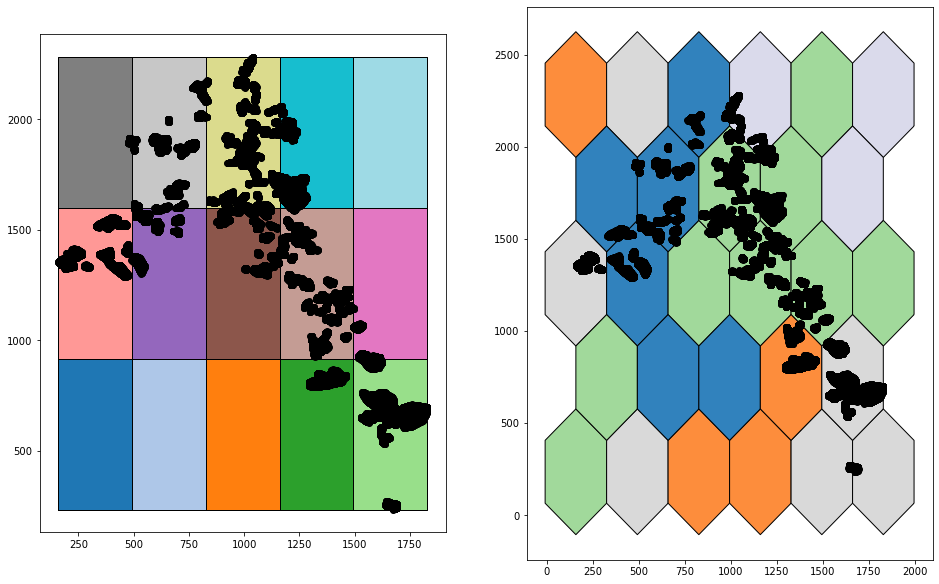

In [230]:
f, ax = plt.subplots(1,2, figsize=(16,16))

blocks = construct_blocks(XYs, tiles_x=5, tiles_y=3, method='unique')
blocks.plot(column='grid_id', edgecolor='black', cmap='tab20',ax=ax[0])

hexgrid = construct_blocks(XYs, tiles_x=5, tiles_y=2, 
                 method='random', n_sims=10, data=X[:100],
                 n_groups=5, shape='hex')
hexgrid.plot(column='grid_id', cmap='tab20c',ax=ax[1], edgecolor='black')

XYs.plot(ax=ax[0], color='black', aspect=1)
XYs.plot(ax=ax[1], color='black', aspect=1)
# ax[0].axis('off'), ax[1].axis('off')
plt.show()

In [89]:
cv = spacv.HBLOCK(5, 5, method='random', buffer_radius=500)

%timeit
i = 0
for tr,te in cv.split(XYs):
    print(i+1, len(tr), len(te), len(tr)+len(te))
    i =+ 1

1 88474 20171 108645
2 89289 4750 94039
2 66133 23040 89173
2 53050 36561 89611
2 70063 24123 94186


In [85]:
XYs.shape

(108645,)

In [90]:
blocks

,geometry,grid_id
0,"POLYGON ((234.000 158.000, 643.800 158.000, 64...",0
1,"POLYGON ((643.800 158.000, 1053.600 158.000, 1...",1
2,"POLYGON ((1053.600 158.000, 1463.400 158.000, ...",2
3,"POLYGON ((1463.400 158.000, 1873.200 158.000, ...",3
4,"POLYGON ((1873.200 158.000, 2283.000 158.000, ...",4
5,"POLYGON ((234.000 714.667, 643.800 714.667, 64...",5
6,"POLYGON ((643.800 714.667, 1053.600 714.667, 1...",6
7,"POLYGON ((1053.600 714.667, 1463.400 714.667, ...",7
8,"POLYGON ((1463.400 714.667, 1873.200 714.667, ...",8
9,"POLYGON ((1873.200 714.667, 2283.000 714.667, ...",9


### save grid

In [253]:
blocks

,geometry,grid_id
0,"POLYGON ((158.000 234.000, 492.000 234.000, 49...",0
1,"POLYGON ((492.000 234.000, 826.000 234.000, 82...",1
2,"POLYGON ((826.000 234.000, 1160.000 234.000, 1...",2
3,"POLYGON ((1160.000 234.000, 1494.000 234.000, ...",3
4,"POLYGON ((1494.000 234.000, 1828.000 234.000, ...",4
5,"POLYGON ((158.000 917.000, 492.000 917.000, 49...",5
6,"POLYGON ((492.000 917.000, 826.000 917.000, 82...",6
7,"POLYGON ((826.000 917.000, 1160.000 917.000, 1...",7
8,"POLYGON ((1160.000 917.000, 1494.000 917.000, ...",8
9,"POLYGON ((1494.000 917.000, 1828.000 917.000, ...",9


In [250]:
from rasterio import features

In [414]:
blocks

,geometry,grid_id
0,"POLYGON ((158.000 234.000, 492.000 234.000, 49...",0
1,"POLYGON ((492.000 234.000, 826.000 234.000, 82...",1
2,"POLYGON ((826.000 234.000, 1160.000 234.000, 1...",2
3,"POLYGON ((1160.000 234.000, 1494.000 234.000, ...",3
4,"POLYGON ((1494.000 234.000, 1828.000 234.000, ...",4
5,"POLYGON ((158.000 917.000, 492.000 917.000, 49...",5
6,"POLYGON ((492.000 917.000, 826.000 917.000, 82...",6
7,"POLYGON ((826.000 917.000, 1160.000 917.000, 1...",7
8,"POLYGON ((1160.000 917.000, 1494.000 917.000, ...",8
9,"POLYGON ((1494.000 917.000, 1828.000 917.000, ...",9


In [415]:
iter_shapes = iter([(shapely.geometry.mapping(polygon), value) for polygon, value in zip(blocks.loc[:, 'geometry'], blocks.loc[:, 'grid_id'])])

In [417]:
next(iter_shapes)

({'type': 'Polygon',
  'coordinates': (((492.0, 234.0),
    (826.0, 234.0),
    (826.0, 917.0),
    (492.0, 917.0),
    (492.0, 234.0)),)},
 1)

In [418]:
img = features.rasterize(iter_shapes, out_shape=(height, width))

In [419]:
np.unique(img)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=uint8)

In [304]:
img.shape

(2357, 1892)

In [281]:
import shapely

In [301]:
meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 1892,
 'height': 2357,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(9.810891648968448e-05, 0.0, 77.03211244126558,
        0.0, -9.810891648968448e-05, 32.25451163012633)}

In [318]:
out_meta = meta.copy()
out_meta.update({"driver": "GTiff",
                 'count': 1,})

with rasterio.open('./look.tiff', "w", **out_meta) as dst:
    # out_image.shape (band, height, width)
    dst.write(img.reshape(-1, height, width))
    dst.write_colormap(1, color_map)

In [316]:
img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [410]:
np.unique(img)

array([  0, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [307]:
import matplotlib as mpl

In [308]:
cmap='Set1'
mpl.cm.get_cmap(cmap).colors

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6))

In [309]:
color_map = {v: c for v, c in enumerate(mpl.cm.get_cmap(cmap).colors)}

In [314]:
color_map

{0: (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 1: (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 2: (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 3: (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 4: (1.0, 0.4980392156862745, 0.0),
 5: (1.0, 1.0, 0.2),
 6: (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 7: (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 8: (0.6, 0.6, 0.6)}

In [264]:
a = {'type': 'Polygon', 'coordinates': (((11.899868449010931, 66.40443537272134), (12.75721845654992, 67.20462871309107), (12.642905122211388, 66.118652036875), (12.414278453534324, 64.26106035387386), (10.899626773548775, 61.83190199918006), (10.64242177128708, 59.94573198259428), (10.55668677053318, 56.544910286022954), (10.385216769025382, 54.001438596990624), (9.32781842639396, 54.001438596990624), (9.32781842639396, 56.65922362036149), (9.69933676299419, 61.48896199616446), (11.899868449010931, 66.40443537272134)),)}


In [265]:
a

{'type': 'Polygon',
 'coordinates': (((11.899868449010931, 66.40443537272134),
   (12.75721845654992, 67.20462871309107),
   (12.642905122211388, 66.118652036875),
   (12.414278453534324, 64.26106035387386),
   (10.899626773548775, 61.83190199918006),
   (10.64242177128708, 59.94573198259428),
   (10.55668677053318, 56.544910286022954),
   (10.385216769025382, 54.001438596990624),
   (9.32781842639396, 54.001438596990624),
   (9.32781842639396, 56.65922362036149),
   (9.69933676299419, 61.48896199616446),
   (11.899868449010931, 66.40443537272134)),)}

In [324]:
p = Point(10,22)

In [326]:
p.coords

In [327]:
p.coords[:]

[(10.0, 22.0)]

In [328]:
p.x

10.0

In [347]:
df

,m
0,POINT (0.000 0.000)
1,POINT (1.000 0.000)
2,POINT (2.000 0.000)
3,POINT (3.000 0.000)
4,POINT (4.000 0.000)
...,...
4459439,POINT (1887.000 2356.000)
4459440,POINT (1888.000 2356.000)
4459441,POINT (1889.000 2356.000)
4459442,POINT (1890.000 2356.000)


In [334]:
small_df = df[:100]

In [337]:
points = small_df.m.apply(lambda x: x.coords[:][0])

In [338]:
points[0]

(0.0, 0.0)

In [343]:
set([1,2,3,4]) - set([2,1]) - set([3])

{4}

In [346]:
points.apply(lambda x: x[0])

0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
      ... 
95    95.0
96    96.0
97    97.0
98    98.0
99    99.0
Name: m, Length: 100, dtype: float64

In [354]:
xs = small_df.m.apply(lambda x: x.coords[:][0][1]).to_numpy().astype(int)

In [371]:
ys = small_df.m.apply(lambda x: x.coords[:][0][0]).to_numpy().astype(int)

In [355]:
xs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [372]:
ys

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [361]:
img = np.arange(200).reshape(-1, 100)

In [364]:
img

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

In [374]:
img[xs, ys] = 0

In [375]:
img

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
        165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 17

In [369]:
img[np.array([1]), np.array([2,3,4])]

array([102, 103, 104])

In [376]:
p = '../data/test_region_near/test_region_near.shp'

In [381]:
p

'../data/test_region_near/test_region_near.shp'

In [384]:
p.split('/')[-1]

'test_region_near.shp'

In [383]:
p.rstrip(p.split('/')[-1])

'../data/test_region_near/'

In [380]:
os.makedirs(p.strip(p.split('/')[-1]))

PermissionError: [WinError 5] Access is denied: '/data'

In [409]:
np.zeros(2, dtype=int)

array([0, 0])

In [3]:
non_crops_shp = gpd.read_file('../data/non_crops/non_crops.shp')

In [85]:
test_polygons_shp = gpd.read_file('../data/test_polygons/test_polygons.shp')

In [4]:
non_crops_shp

,id,district,geometry
0,3,kullu,"POLYGON ((77.12229 32.09380, 77.12245 32.09365..."
1,3,kullu,"POLYGON ((77.12374 32.09842, 77.12408 32.09806..."
2,3,kullu,"POLYGON ((77.12328 32.09461, 77.12402 32.09416..."
3,3,kullu,"POLYGON ((77.12413 32.09399, 77.12493 32.09349..."
4,3,kullu,"POLYGON ((77.12362 32.09389, 77.12370 32.09376..."
...,...,...,...
75,3,Kullu,"POLYGON ((77.15439 32.13051, 77.15491 32.13012..."
76,3,Kullu,"POLYGON ((77.15646 32.13263, 77.15665 32.13263..."
77,3,Kullu,"POLYGON ((77.15678 32.14174, 77.15707 32.14194..."
78,3,Kullu,"POLYGON ((77.15950 32.14368, 77.16030 32.14245..."


In [12]:
from spacv.grid_builder import construct_blocks, assign_pt_to_grid

In [7]:
blocks = construct_blocks(non_crops_shp, tiles_x=4, tiles_y=3, method='unique')

In [8]:
blocks

,geometry,grid_id
0,"POLYGON ((77.06561 32.03049, 77.10208 32.03049...",0
1,"POLYGON ((77.10208 32.03049, 77.13855 32.03049...",1
2,"POLYGON ((77.13855 32.03049, 77.17502 32.03049...",2
3,"POLYGON ((77.17502 32.03049, 77.21149 32.03049...",3
4,"POLYGON ((77.06561 32.09750, 77.10208 32.09750...",4
5,"POLYGON ((77.10208 32.09750, 77.13855 32.09750...",5
6,"POLYGON ((77.13855 32.09750, 77.17502 32.09750...",6
7,"POLYGON ((77.17502 32.09750, 77.21149 32.09750...",7
8,"POLYGON ((77.06561 32.16451, 77.10208 32.16451...",8
9,"POLYGON ((77.10208 32.16451, 77.13855 32.16451...",9


In [51]:
import shapely

In [59]:
iter_shapes = iter([(shapely.geometry.mapping(polygon), value + 1) for polygon, value in
                        zip(non_crops_shp.dropna().geometry, non_crops_shp.dropna().id)])

In [60]:
next(iter_shapes)

({'type': 'Polygon',
  'coordinates': (((77.12228914960477, 32.09379785410108),
    (77.1224527724988, 32.09364591855662),
    (77.12217227610903, 32.092623275468874),
    (77.12198527851584, 32.092640806493236),
    (77.12187424869488, 32.09234862275388),
    (77.12130741224054, 32.09245380890005),
    (77.12128988121619, 32.0926583375176),
    (77.1205594218678, 32.09272261794026),
    (77.1204191736729, 32.092956364931744),
    (77.12190346706882, 32.09379785410108),
    (77.12228914960477, 32.09379785410108)),)},
 4)

In [61]:
from shapely.geometry import shape

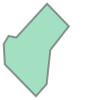

In [62]:
shape(next(iter_shapes)[0])

In [54]:
shapely.geometry.mapping(non_crops_shp.geometry)

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((77.12228914960477, 32.09379785410108),
      (77.1224527724988, 32.09364591855662),
      (77.12217227610903, 32.092623275468874),
      (77.12198527851584, 32.092640806493236),
      (77.12187424869488, 32.09234862275388),
      (77.12130741224054, 32.09245380890005),
      (77.12128988121619, 32.0926583375176),
      (77.1205594218678, 32.09272261794026),
      (77.1204191736729, 32.092956364931744),
      (77.12190346706882, 32.09379785410108),
      (77.12228914960477, 32.09379785410108)),)},
   'bbox': (77.1204191736729,
    32.09234862275388,
    77.1224527724988,
    32.09379785410108)},
  {'id': '1',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': (((77.12373984187069, 32.09841873993896),
      (77.12408461868313, 32.09806227577695),
      (77.12379243494378, 32.09768828059057

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

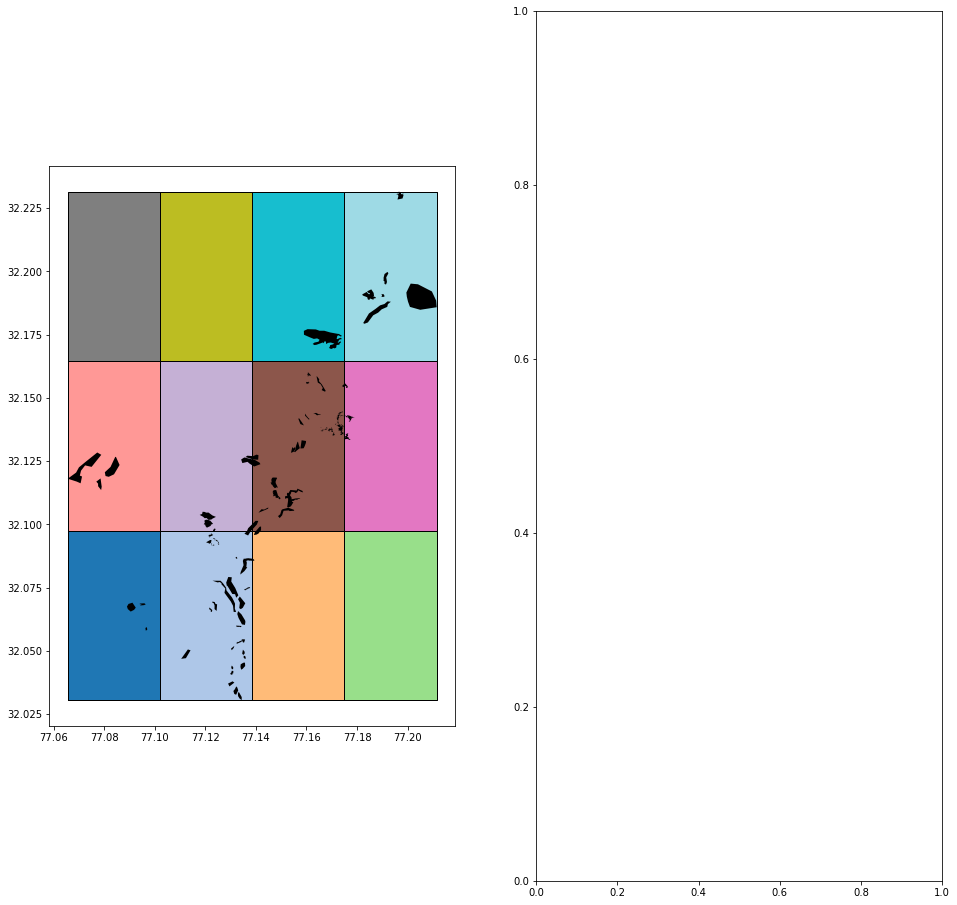

In [14]:
f, ax = plt.subplots(1,2, figsize=(16,16))

blocks.plot(column='grid_id', edgecolor='black', cmap='tab20',ax=ax[0])

# hexgrid = construct_blocks(XYs, tiles_x=5, tiles_y=2, 
#                  method='random', n_sims=10, data=X[:100],
#                  n_groups=5, shape='hex')
# hexgrid.plot(column='grid_id', cmap='tab20c',ax=ax[1], edgecolor='black')

non_crops_shp.plot(ax=ax[0], color='black', aspect=1)
# ax[0].axis('off'), ax[1].axis('off')
plt.show()

In [ ]:
non_crops_shp.geometry

In [45]:
polygons = non_crops_shp.dropna()
grid = blocks

In [48]:
features = assign_polygons_to_grid(polygons, grid)

C:\Users\lida\AppData\Local\Temp/ipykernel_104/1048192942.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_centroid = grid.geometry.centroid
C:\Users\lida\AppData\Local\Temp/ipykernel_104/1048192942.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_centroid = border_polygons.centroid


In [47]:
from spacv.utils import geometry_to_2d
from sklearn.neighbors import BallTree

def assign_polygons_to_grid(polygons, grid, distance_metric='euclidean', random_state=None):
    """
    Spatial join polygons to grids. Reassign border points to nearest grid based on centroid distance. 
    """
    np.random.seed(random_state)
    # Equate spatial reference systems if defined 
    if not grid.crs == polygons.crs:
        grid.crs = polygons.crs        
    polygons = gpd.sjoin(polygons, grid, how='left' , op='within')[['geometry', 'grid_id']]
    # In rare cases, points will sit at the border separating two grids
    if polygons['grid_id'].isna().any():
        # Find border pts and assign to nearest grid centroid
        grid_centroid = grid.geometry.centroid
        grid_centroid = geometry_to_2d(grid_centroid)
        border_polygon_index = polygons['grid_id'].isna()
        border_centroid = polygons[border_polygon_index].geometry.centroid
        border_centroid = geometry_to_2d(border_centroid)      
        
        # Update border pt grid IDs
        tree = BallTree(grid_centroid, metric=distance_metric) 
        grid_id = tree.query(border_centroid, k=1, return_distance=False).flatten()
        grid_id = grid.loc[grid_id, 'grid_id'].values
        polygons.loc[border_polygon_index, 'grid_id'] = grid_id
    return polygons


In [ ]:
test_polygons/test_polygons

In [71]:
from spacv.grid_builder import construct_grid

In [83]:
polygons_gpd = gpd.GeoDataFrame([shape(poly) for poly in test_features], columns=['geometry'])
grid_all = construct_grid(polygons_gpd, tiles_x=4, tiles_y=4, shape='square')
grid_all['grid_id'] = grid_all.index
polygons_gpd = assign_polygons_to_grid(polygons_gpd, grid_all)
grid_valid = grid_all.loc[sorted(polygons_gpd.grid_id.unique().astype(int)), :].reset_index(drop=True)
grid_valid = grid_valid.rename(columns={'grid_id': 'grid_id_valid'})

[77.02428226 31.89743173 77.1664693  32.01297157]
[77.02428226 31.89743173 77.1664693  32.01297157]
[77.02428226 31.89743173 77.1664693  32.01297157]


In [84]:
grid_valid

,geometry,grid_id_valid
0,"POLYGON ((77.05983 31.89743, 77.09538 31.89743...",1
1,"POLYGON ((77.09538 31.89743, 77.13092 31.89743...",2
2,"POLYGON ((77.13092 31.89743, 77.16647 31.89743...",3
3,"POLYGON ((77.05983 31.92632, 77.09538 31.92632...",5
4,"POLYGON ((77.09538 31.92632, 77.13092 31.92632...",6
5,"POLYGON ((77.13092 31.92632, 77.16647 31.92632...",7
6,"POLYGON ((77.05983 31.95520, 77.09538 31.95520...",9
7,"POLYGON ((77.09538 31.95520, 77.13092 31.95520...",10
8,"POLYGON ((77.13092 31.95520, 77.16647 31.95520...",11
9,"POLYGON ((77.02428 31.98409, 77.05983 31.98409...",12


In [75]:
polygons_gpd.grid_id.unique()

array([ 6.,  7., 11., 10., 14., 13.,  9., 15.,  5.,  2.,  3., 12.,  1.])

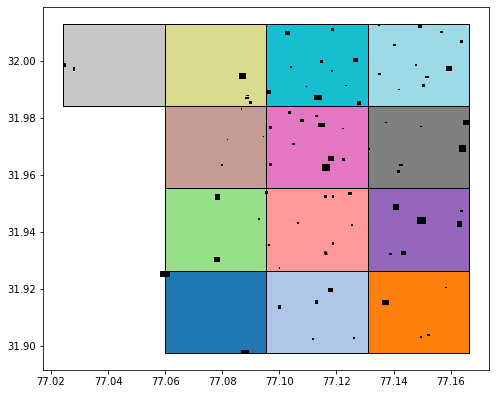

In [86]:
f, ax = plt.subplots(1,1, figsize=(8,8))
grid_valid.plot(column='grid_id_valid', edgecolor='black', cmap='tab20',ax=ax)
test_polygons_shp.plot(ax=ax, color='black', aspect=1)
# ax[0].axis('off'), ax[1].axis('off')
plt.show()

In [81]:
grid_valid.total_bounds

array([77.02428226, 31.89743173, 77.1664693 , 32.01297157])

In [98]:
polygons_gpd

,geometry,grid_id
0,"POLYGON ((77.11557 31.93298, 77.11634 31.93331...",6.0
1,"POLYGON ((77.11565 31.95197, 77.11565 31.95296...",6.0
2,"POLYGON ((77.11832 31.95196, 77.11832 31.95287...",6.0
3,"POLYGON ((77.12413 31.95305, 77.12413 31.95407...",6.0
4,"POLYGON ((77.13835 31.93178, 77.13835 31.93273...",7.0
...,...,...
75,"POLYGON ((77.07712 31.92951, 77.07712 31.93122...",5.0
76,"POLYGON ((77.02768 31.99640, 77.02768 31.99780...",12.0
77,"POLYGON ((77.02428 31.99784, 77.02428 31.99902...",12.0
78,"POLYGON ((77.05834 31.92429, 77.05834 31.92624...",1.0


In [99]:
iter_shapes = iter([(shapely.geometry.mapping(polygon), value + 1) for polygon, value in zip(polygons_gpd.geometry, polygons_gpd.grid_id)])
img = rasterio.features.rasterize(iter_shapes, out_shape=(meta['height'], meta['width']))

In [103]:
np.unique(img)

array([0.], dtype=float32)

In [100]:
next(iter_shapes)

({'type': 'Polygon',
  'coordinates': (((77.11556966552818, 31.932980415461877),
    (77.11634053329385, 31.933312941652222),
    (77.11672809664566, 31.932814151915665),
    (77.11695382035603, 31.93200451643682),
    (77.11591463950066, 31.931802106453013),
    (77.11556966552818, 31.932980415461877)),)},
 7.0)

In [101]:
img = rasterio.features.rasterize(iter_shapes, out_shape=(meta['height'], meta['width']))

In [108]:
from spacv.grid_builder import assign_pt_to_grid, construct_grid, assign_randomized, assign_systematic, \
    assign_optimized_random

In [104]:
def assign_grid_to_fold(XYs, grid, tiles_x, tiles_y, method='unique', shape='square',
                        direction='diagonal', data=None, n_groups=5, n_sims=10,
                        distance_metric='euclidean', random_state=None):
    # Set grid assignment method
    if method == 'unique':
        grid['grid_id'] = grid.index
    elif method == 'systematic':
        if shape != 'square':
            raise Exception("systematic grid assignment method does not work for irregular grids.")
        grid['grid_id'] = assign_systematic(grid, tiles_x, tiles_y, direction)
    elif method == 'random':
        grid['grid_id'] = assign_randomized(grid, n_groups, random_state)
    elif method == 'optimized_random':
        grid['grid_id'] = assign_optimized_random(grid, XYs, data,
                                                  n_groups,
                                                  n_sims,
                                                  distance_metric)
    else:
        raise ValueError("Method not recognised. Choose between: unique, systematic, random or optimized_random.")
    return grid

In [109]:
assign_grid_to_fold(polygons_gpd, grid_valid, 4,4, method='random')

,geometry,grid_id_valid,grid_id
0,"POLYGON ((77.05983 31.89743, 77.09538 31.89743...",1,2
1,"POLYGON ((77.09538 31.89743, 77.13092 31.89743...",2,1
2,"POLYGON ((77.13092 31.89743, 77.16647 31.89743...",3,2
3,"POLYGON ((77.05983 31.92632, 77.09538 31.92632...",5,3
4,"POLYGON ((77.09538 31.92632, 77.13092 31.92632...",6,4
5,"POLYGON ((77.13092 31.92632, 77.16647 31.92632...",7,3
6,"POLYGON ((77.05983 31.95520, 77.09538 31.95520...",9,3
7,"POLYGON ((77.09538 31.95520, 77.13092 31.95520...",10,4
8,"POLYGON ((77.13092 31.95520, 77.16647 31.95520...",11,3
9,"POLYGON ((77.02428 31.98409, 77.05983 31.98409...",12,3


In [112]:
fold = assign_grid_to_fold(polygons_gpd, grid_valid, 4,4, method='random')

In [114]:
fold.head()

,geometry,grid_id_valid,grid_id
0,"POLYGON ((77.05983 31.89743, 77.09538 31.89743...",1,2
1,"POLYGON ((77.09538 31.89743, 77.13092 31.89743...",2,3
2,"POLYGON ((77.13092 31.89743, 77.16647 31.89743...",3,2
3,"POLYGON ((77.05983 31.92632, 77.09538 31.92632...",5,1
4,"POLYGON ((77.09538 31.92632, 77.13092 31.92632...",6,1


In [115]:
fold = fold.rename(columns={'grid_id': 'fold_id', 'grid_id_valid': 'grid_id'})

In [116]:
fold.head()

,geometry,grid_id,fold_id
0,"POLYGON ((77.05983 31.89743, 77.09538 31.89743...",1,2
1,"POLYGON ((77.09538 31.89743, 77.13092 31.89743...",2,3
2,"POLYGON ((77.13092 31.89743, 77.16647 31.89743...",3,2
3,"POLYGON ((77.05983 31.92632, 77.09538 31.92632...",5,1
4,"POLYGON ((77.09538 31.92632, 77.13092 31.92632...",6,1


In [118]:
from shapely.ops import cascaded_union

In [117]:
fold.geometry[fold.fold_id==1]

3     POLYGON ((77.05983 31.92632, 77.09538 31.92632...
4     POLYGON ((77.09538 31.92632, 77.13092 31.92632...
11    POLYGON ((77.09538 31.98409, 77.13092 31.98409...
Name: geometry, dtype: geometry

In [121]:
fold_df = []
for f_id in fold.fold_id.unique():
    fold_df.append(cascaded_union(fold.geometry[fold.fold_id==f_id]))
fold_df = gpd.GeoDataFrame(fold_df, columns=['geometry'])

In [127]:
polygons_gpd['fold_id'] = polygons_gpd.grid_id.map(map_grid_to_fold)

In [128]:
polygons_gpd

,geometry,grid_id,fold_d
0,"POLYGON ((77.11557 31.93298, 77.11634 31.93331...",6.0,1
1,"POLYGON ((77.11565 31.95197, 77.11565 31.95296...",6.0,1
2,"POLYGON ((77.11832 31.95196, 77.11832 31.95287...",6.0,1
3,"POLYGON ((77.12413 31.95305, 77.12413 31.95407...",6.0,1
4,"POLYGON ((77.13835 31.93178, 77.13835 31.93273...",7.0,0
...,...,...,...
75,"POLYGON ((77.07712 31.92951, 77.07712 31.93122...",5.0,1
76,"POLYGON ((77.02768 31.99640, 77.02768 31.99780...",12.0,0
77,"POLYGON ((77.02428 31.99784, 77.02428 31.99902...",12.0,0
78,"POLYGON ((77.05834 31.92429, 77.05834 31.92624...",1.0,2


In [126]:
map_grid_to_fold = {grid_id: fold_id for grid_id, fold_id in zip(fold.grid_id, fold.fold_id)}

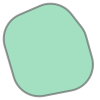

In [135]:
polygons_gpd.loc[0, 'geometry'].buffer(0.001)

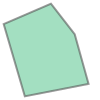

In [136]:
polygons_gpd.loc[0, 'geometry']

In [134]:
polygons_gpd.loc[0, 'geometry'].bounds

(77.11556966552818, 31.931802106453013, 77.11695382035603, 31.933312941652222)

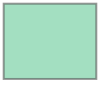

In [139]:
fold.loc[0,'geometry']

In [147]:
polygons_gpd.loc[:2, 'geometry'].buffer(0.001).difference(polygons_gpd.loc[1, 'geometry']).unary_union()

TypeError: 'MultiPolygon' object is not callable

In [150]:
polygons_gpd.loc[0, 'geometry'].buffer(0.001).union(polygons_gpd.loc[0, 'geometry'])

AttributeError: 'Polygon' object has no attribute 'dtype'

In [154]:
for p in polygons_gpd.loc[:2].geometry:
    print()

In [168]:
for i,j in zip(grid.geometry, grid.grid_id):
    print(i,j)

POLYGON ((77.06561134784448 32.03049297887348, 77.10207978125919 32.03049297887348, 77.10207978125919 32.0975030000498, 77.06561134784448 32.0975030000498, 77.06561134784448 32.03049297887348)) 0
POLYGON ((77.10207978125919 32.03049297887348, 77.13854821467389 32.03049297887348, 77.13854821467389 32.0975030000498, 77.10207978125919 32.0975030000498, 77.10207978125919 32.03049297887348)) 1
POLYGON ((77.13854821467389 32.03049297887348, 77.17501664808859 32.03049297887348, 77.17501664808859 32.0975030000498, 77.13854821467389 32.0975030000498, 77.13854821467389 32.03049297887348)) 2
POLYGON ((77.17501664808859 32.03049297887348, 77.2114850815033 32.03049297887348, 77.2114850815033 32.0975030000498, 77.17501664808859 32.0975030000498, 77.17501664808859 32.03049297887348)) 3
POLYGON ((77.06561134784448 32.0975030000498, 77.10207978125919 32.0975030000498, 77.10207978125919 32.16451302122612, 77.06561134784448 32.16451302122612, 77.06561134784448 32.0975030000498)) 4
POLYGON ((77.1020797812

In [173]:
grid.loc[1,'geometry']

(77.10207978125919, 32.03049297887348, 77.13854821467389, 32.0975030000498)

In [179]:
grid.loc[1,'geometry'].buffer(0.01).difference(grid.loc[1,'geometry']).type

'Polygon'

In [158]:
grid

,geometry,grid_id
0,"POLYGON ((77.06561 32.03049, 77.10208 32.03049...",0
1,"POLYGON ((77.10208 32.03049, 77.13855 32.03049...",1
2,"POLYGON ((77.13855 32.03049, 77.17502 32.03049...",2
3,"POLYGON ((77.17502 32.03049, 77.21149 32.03049...",3
4,"POLYGON ((77.06561 32.09750, 77.10208 32.09750...",4
5,"POLYGON ((77.10208 32.09750, 77.13855 32.09750...",5
6,"POLYGON ((77.13855 32.09750, 77.17502 32.09750...",6
7,"POLYGON ((77.17502 32.09750, 77.21149 32.09750...",7
8,"POLYGON ((77.06561 32.16451, 77.10208 32.16451...",8
9,"POLYGON ((77.10208 32.16451, 77.13855 32.16451...",9


In [174]:
grid.geometry.type

0     Polygon
1     Polygon
2     Polygon
3     Polygon
4     Polygon
5     Polygon
6     Polygon
7     Polygon
8     Polygon
9     Polygon
10    Polygon
11    Polygon
dtype: object

In [180]:
s = {'type': 'MultiPolygon',
 'coordinates': [(((77.1295914788502, 32.08075049475572),
    (77.17053828017674, 32.08075049475572),
    (77.17053828017674, 32.03049297887348),
    (77.1295914788502, 32.03049297887348),
    (77.1295914788502, 32.053428516306084),
    (77.12994881668556, 32.054698341828164),
    (77.1298168403477, 32.05496791051826),
    (77.12974944817518, 32.05502407066203),
    (77.12965116792357, 32.05508303881299),
    (77.1295914788502, 32.05512062082215),
    (77.1295914788502, 32.08075049475572)),),
  (((77.1295914788502, 32.05497599492755),
    (77.12971294408173, 32.054931406424835),
    (77.12970732806735, 32.054774158022276),
    (77.1295914788502, 32.05480162742428),
    (77.1295914788502, 32.05497599492755)),)]}

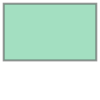

In [193]:
grid.loc[:2, 'geometry'].unary_union

In [187]:
import numpy as np
from shapely.geometry import Point
from geopandas import GeoSeries
xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000
xc = (xmax - xmin) * np.random.random(2000) + xmin
yc = (ymax - ymin) * np.random.random(2000) + ymin
pts = GeoSeries([Point(x, y) for x, y in zip(xc, yc)])

In [188]:
circles = pts.buffer(2000)

In [189]:
circles

0       POLYGON ((1045001.628 169371.100, 1044991.998 ...
1       POLYGON ((1026178.029 267259.248, 1026168.398 ...
2       POLYGON ((1029495.134 146618.205, 1029485.503 ...
3       POLYGON ((1011210.023 151504.250, 1011200.392 ...
4       POLYGON ((1001918.745 143429.588, 1001909.114 ...
                              ...                        
1995    POLYGON ((971419.411 214975.700, 971409.781 21...
1996    POLYGON ((1019453.576 172463.584, 1019443.946 ...
1997    POLYGON ((1036536.724 266071.110, 1036527.093 ...
1998    POLYGON ((1047089.929 221014.868, 1047080.298 ...
1999    POLYGON ((1080068.209 243777.467, 1080058.578 ...
Length: 2000, dtype: geometry

In [192]:
mp = circles.unary_union

In [199]:
bands_name = ['blue', 'green', 'red', 'nir', 'ndvi']

In [200]:
n = 53

In [204]:
ndvi_columsn = np.arange(bands_name.index('ndvi'), len(bands_name)*n, len(bands_name))

In [205]:
ndvi_columsn.shape

(53,)

In [206]:
365/7

52.142857142857146

In [211]:
a = np.arange(60)

In [221]:
a.reshape(1, -1, 4)

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39],
        [40, 41, 42, 43],
        [44, 45, 46, 47],
        [48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59]]])

In [222]:
a.reshape(1, -1, 4).max(axis=2)

array([[ 3,  7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59]])

In [225]:
math.floor(53/4)

13

In [226]:
a[::4]

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56])

In [227]:
b = np.arange(53)

In [229]:
b[::4]

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52])

### new coordinates

In [236]:
train_area_shp = gpd.read_file('../data/train_area/train_area.shp')

In [297]:
rasterio.transform.xy(meta_pred['transform'], 0, 0)

(77.03216149572383, 32.254462575668086)

In [298]:
rasterio.transform.xy(meta_pred['transform'], meta_pred['height'], meta_pred['width'])

(77.21778356572231, 32.0232198595019)

In [293]:
meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 4,
 'crs': CRS.from_epsg(32643),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 3600000.0)}

In [237]:
train_area_shp.total_bounds

array([77.03217968, 32.02331729, 77.2176813 , 32.25444632])

In [238]:
minx, miny, maxx, maxy = train_area_shp.total_bounds

In [241]:
height, width = 2357, 1892

In [260]:
np.linspace(minx, maxx, width)

array([77.03217968, 77.03227778, 77.03237588, ..., 77.2174851 ,
       77.2175832 , 77.2176813 ])

In [280]:
np.linspace(maxx, minx, width)


array([77.2176813 , 77.2175832 , 77.2174851 , ..., 77.03237588,
       77.03227778, 77.03217968])

In [265]:
xs = np.tile(np.linspace(minx, maxx, width), height)

In [266]:
xs

array([77.03217968, 77.03227778, 77.03237588, ..., 77.2174851 ,
       77.2175832 , 77.2176813 ])

In [261]:
np.linspace(miny, maxy, height, endpoint=False)

array([32.02331729, 32.02341539, 32.0235135 , ..., 32.25425011,
       32.25434822, 32.25444632])

In [267]:
ys = np.linspace(miny, maxy, height, endpoint=False).repeat(width)

In [268]:
ys

array([32.02331729, 32.02331729, 32.02331729, ..., 32.25444632,
       32.25444632, 32.25444632])

In [269]:
points = [shapely.geometry.Point(x, y) for x,y in zip(xs, ys)]

In [271]:
points_gdf = gpd.GeoDataFrame(points, columns=['geometry'])

In [276]:
points_gdf.head()

,geometry
0,POINT (77.03218 32.02332)
1,POINT (77.03228 32.02332)
2,POINT (77.03238 32.02332)
3,POINT (77.03247 32.02332)
4,POINT (77.03257 32.02332)


In [283]:
gpd.GeoSeries(gpd.points_from_xy(xs[:2], ys[:2]))

0    POINT (77.03218 32.02332)
1    POINT (77.03228 32.02332)
dtype: geometry

In [274]:
features

,geometry,grid_id
0,"POLYGON ((77.12229 32.09380, 77.12245 32.09365...",1.0
1,"POLYGON ((77.12374 32.09842, 77.12408 32.09806...",5.0
2,"POLYGON ((77.12328 32.09461, 77.12402 32.09416...",1.0
3,"POLYGON ((77.12413 32.09399, 77.12493 32.09349...",1.0
4,"POLYGON ((77.12362 32.09389, 77.12370 32.09376...",1.0
...,...,...
75,"POLYGON ((77.15439 32.13051, 77.15491 32.13012...",6.0
76,"POLYGON ((77.15646 32.13263, 77.15665 32.13263...",6.0
77,"POLYGON ((77.15678 32.14174, 77.15707 32.14194...",6.0
78,"POLYGON ((77.15950 32.14368, 77.16030 32.14245...",6.0


In [278]:
test_rc_polygons[0]

array([[ 9999,  6503],
       [10006,  6500],
       [10010,  6505],
       [10012,  6514],
       [10002,  6516],
       [ 9999,  6503]])

In [275]:
test_polygons[0]

array([[ 699992.24769696, 3534960.58031005],
       [ 700064.41460427, 3534998.873502  ],
       [ 700102.14075799, 3534944.28659676],
       [ 700125.2386566 , 3534854.93564383],
       [ 700027.41890862, 3534830.57288344],
       [ 699992.24769696, 3534960.58031005]])

In [259]:
test_features

[{'type': 'Polygon',
  'coordinates': [[(77.11556966552818, 31.932980415461877),
    (77.11634053329385, 31.933312941652222),
    (77.11672809664566, 31.932814151915665),
    (77.11695382035603, 31.93200451643682),
    (77.11591463950066, 31.931802106453013),
    (77.11556966552818, 31.932980415461877)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.11564632641094, 31.951965011532938),
    (77.11564632641094, 31.952962380430723),
    (77.11683882903188, 31.952962380430723),
    (77.11683882903188, 31.951965011532938),
    (77.11564632641094, 31.951965011532938)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.11832093943218, 31.951957784182568),
    (77.11832093943218, 31.95286842585163),
    (77.11929197728065, 31.95286842585163),
    (77.11929197728065, 31.951957784182568),
    (77.11832093943218, 31.951957784182568)]]},
 {'type': 'Polygon',
  'coordinates': [[(77.12413013077123, 31.953047300833003),
    (77.12413013077123, 31.954073566721306),
    (77.12535670489562, 31.9540735667213

In [319]:
xys = np.concatenate([xs[:2].reshape(-1,1), ys[:2].reshape(-1, 1)], axis=1)

In [323]:
xys.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [320]:
gpd.points_from_xy(xys)

TypeError: points_from_xy() missing 1 required positional argument: 'y'

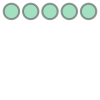

In [325]:
from shapely.ops import unary_union
polygons = [Point(i, 0).buffer(0.4) for i in range(5)]
unary_union(polygons)

In [326]:
unary_union(polygons).type

'MultiPolygon'